In [149]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sympy import symbols, cos, sin
from sympy.plotting import plot_parametric
from math import sin,cos
import random
import scipy.stats as stats

# Лабораторная работа 1 , задание 2(b) ,Particle Filter
Реализация фильтра частиц для отслеживания координати ориентации в соответствии с odometry motion model

# Фильтр частиц
$$ E[f(x)] = \int f(x)  \frac{\pi(x)}{\int \pi(u) du} dx = \int \frac{f(x)\pi(x) dx}{\int \pi(u) du} = 
\int \frac{f(x) \frac{\pi(x)}{q(x)} q(x) dx} {\int \frac{\pi(u)}{q(u)} du}$$
$$ \pi(x)  = p(x_t|y_1,...y_t)$$
$$ w(x_t) = p(y_t|x_t)$$
$$ q(x_t) = p(x_t|y_1...y_{t-1}) $$
$$ \pi(x_t) = w(x_t) \cdot q(x_t)$$

Считывание показаний сенсоров и одометрии

In [76]:
f = open('/data files/sensor_data_pf.dat')
for line in f:
    q = line.split()
    print(q)

['ODOMETRY', '0.100068080139', '0.100249642432', '-0.000326992241362']
['SENSOR', '1', '2.08219220544', '0.311724182123']
['SENSOR', '2', '4.01188450412', '1.44126366316']
['ODOMETRY', '0.100770135385', '0.0999830371692', '0.000283319078732']
['SENSOR', '1', '2.03292033382', '0.309629930574']
['SENSOR', '2', '3.67779686283', '1.3616405663']
['ODOMETRY', '0.100250871824', '0.0999613218142', '-0.000425899489536']
['SENSOR', '1', '1.91136870178', '0.177168372291']
['SENSOR', '2', '4.08834234003', '1.33657402646']
['ODOMETRY', '0.0985096726563', '0.100081615233', '-0.000571339302397']
['SENSOR', '1', '1.98574147997', '0.089747632785']
['SENSOR', '2', '3.93046602632', '1.29955605297']
['ODOMETRY', '0.101801020564', '0.100072032353', '-0.000788337604257']
['SENSOR', '1', '1.67053917265', '0.061660128389']
['SENSOR', '2', '3.93135144955', '1.20012845634']
['ODOMETRY', '0.100732548455', '0.0996154508379', '-0.000105935989332']
['SENSOR', '1', '1.69509870017', '-0.00971084225084']
['SENSOR', '2

Считывание координат датчиков

In [78]:
L = []
myfile = open('/data files/landmarks.dat')
for line in myfile:
    L.append( [int(x) for x in line.split()])
print(L)
number_of_sensors = len(L)*2

[[1, 2, 1], [2, 0, 4], [3, 2, 7], [4, 9, 2], [5, 10, 5], [6, 9, 8], [7, 5, 5], [8, 5, 3], [9, 5, 9]]


In [81]:
def conc(Y,x):
    if len(Y) == 0:
        return x
    else:
        return np.vstack((Y,x))

In [94]:
def nrml(ang):
    while ang >= 2 * math.pi:
        ang-= 2*math.pi
    while ang < 0:
        ang += 2*math.pi
    return ang

In [151]:
def resample(w):
    x_samples = x.copy()
    w_indices = [i for i in range(len(w))]
    w_dist = stats.rv_discrete(values=(w_indices, w))
    for j in range(N):
        resample_index = w_dist.rvs()
        x[j] = x_samples[resample_index]
    return x

In [121]:
def f(x):
    x[0] = nrml(x[0])
    e1 = math.sqrt(alpha[0]  * abs(deltar1) +  alpha[1] *  deltat)
    e2 = math.sqrt(alpha[2]  * deltat +  alpha[3] *  (abs(deltar1) + abs(deltar2)))
    e3 = math.sqrt(alpha[0]  * abs(deltar2) +  alpha[1] *  deltat)
    Dr1 = nrml(deltar1 +  np.random.normal(0,e1))
    Dr2 = nrml(deltar2 +  np.random.normal(0,e2))
    Dt  = deltat  +  np.random.normal(0,e3)
    return np.array([nrml(x[0] + Dr1 + Dr2 ), x[1] + Dt * cos(x[0]+ Dr1) , x[2] + Dt * sin(x[0] +  Dr1)])

# Фильтр частиц  для расстояний

In [152]:
# Начальные распределения
m = []
P = []
m.append([0,0,0])
myfile = open('/data files/sensor_data_pf.dat')
R = []
n = 3
k = 0
nn = 0 
N = 10
Y = 0
w = [1/N] * N
x = np.array([[random.random()]*n for i in range(N)])
alpha = [0.1,0.1,0.05,0.05]
nums = []
for line in myfile:
    nn = nn+1
    q = line.split()
    if q[0] == 'ODOMETRY':
        if(len(nums)!= 0):
            # нормировка
            s = sum(w)
            w /= s
            # Вычисление оценки матожидания
            m_ = [0.0] * n
            for i in range(N):
                m_  = m_ + w[i] *x[i]
                m_[0] = nrml(m_[0])
            m.append(m_)
        # Ресемплинг
            x = resample(w)
            w = [1/N]*N
        #Берем дельты из Одометрии
        deltar1 = float(q[1])
        deltat = float(q[2])
        deltar2 = float(q[3])
        
        # движение частиц
        for i in range(N):
            x[i] = f(x[i])
        w = np.array([1.0] * N)
        nums = []
        k = 0
    else:
        k = k+1
        num = int(q[1])
        nums.append(num)
        Y = float(q[2])
        for i in range(N):
            delta_x = L[num - 1][1] - x[i][1]
            delta_y = L[num - 1][2] - x[i][2]
            qq = (delta_x * delta_x) + (delta_y * delta_y)
            qq = math.sqrt(qq)
            w[i] *= math.exp(-(qq - Y)*(qq - Y)/ 0.08)

num = 
1
ODOMETRY 0.100068080139 0.100249642432 -0.000326992241362

num = 
2
SENSOR 1 2.08219220544 0.311724182123

num = 
3
SENSOR 2 4.01188450412 1.44126366316

num = 
4
ODOMETRY 0.100770135385 0.0999830371692 0.000283319078732

num = 
5
SENSOR 1 2.03292033382 0.309629930574

num = 
6
SENSOR 2 3.67779686283 1.3616405663

num = 
7
ODOMETRY 0.100250871824 0.0999613218142 -0.000425899489536

num = 
8
SENSOR 1 1.91136870178 0.177168372291

num = 
9
SENSOR 2 4.08834234003 1.33657402646

num = 
10
ODOMETRY 0.0985096726563 0.100081615233 -0.000571339302397

num = 
11
SENSOR 1 1.98574147997 0.089747632785

num = 
12
SENSOR 2 3.93046602632 1.29955605297

num = 
13
ODOMETRY 0.101801020564 0.100072032353 -0.000788337604257

num = 
14
SENSOR 1 1.67053917265 0.061660128389

num = 
15
SENSOR 2 3.93135144955 1.20012845634

num = 
16
ODOMETRY 0.100732548455 0.0996154508379 -0.000105935989332

num = 
17
SENSOR 1 1.69509870017 -0.00971084225084

num = 
18
SENSOR 2 3.92006968797 1.17072603097

num = 
1

num = 
339
SENSOR 9 4.77739612534 -0.858203342542

num = 
340
SENSOR 2 2.51769849113 2.67416607463

num = 
341
SENSOR 3 1.24645217892 -0.852893599077

num = 
342
SENSOR 7 4.03471989557 -1.8113886332

num = 
343
ODOMETRY -0.000159615464035 0.100138867779 -9.50566744297e-05

num = 
344
SENSOR 9 4.85310064919 -0.958324651792

num = 
345
SENSOR 2 2.41599610928 2.73803779326

num = 
346
SENSOR 3 1.1553906277 -0.952297527875

num = 
347
SENSOR 7 4.05847660943 -1.83829462387

num = 
348
ODOMETRY 0.000397083245112 0.0999345504925 -0.000473283143359

num = 
349
SENSOR 9 4.83134105102 -0.987132642593

num = 
350
SENSOR 2 2.66361378317 2.73601068382

num = 
351
SENSOR 3 1.18927270664 -0.98716043606

num = 
352
SENSOR 7 4.1162336909 -1.8197753718

num = 
353
ODOMETRY -0.000125470763969 0.0999261518626 -0.000151801883516

num = 
354
SENSOR 9 4.61875783758 -0.96518540751

num = 
355
SENSOR 2 2.62689728182 2.80385923962

num = 
356
SENSOR 3 1.11000285571 -1.04644745072

num = 
357
SENSOR 7 4.18567720

num = 
645
SENSOR 9 0.976385093206 -2.21825060068

num = 
646
SENSOR 3 4.60087364024 -2.49833542789

num = 
647
SENSOR 6 3.85663249854 -0.473587765132

num = 
648
SENSOR 7 4.69832908576 -1.72444148595

num = 
649
ODOMETRY 0.000347169255971 0.100119005274 0.000472676508502

num = 
650
SENSOR 9 1.04654924484 -2.27392503998

num = 
651
SENSOR 3 4.51360132672 -2.52631209875

num = 
652
SENSOR 6 3.80488060575 -0.493098131544

num = 
653
SENSOR 7 4.93118784271 -1.73826666846

num = 
654
ODOMETRY 0.00062789372328 0.0998413041241 -0.000574518763401

num = 
655
SENSOR 9 1.28463314263 -2.34744957796

num = 
656
SENSOR 3 4.66418397437 -2.52120194012

num = 
657
SENSOR 6 3.69287759951 -0.60259976732

num = 
658
SENSOR 7 4.96873311865 -1.67093594865

num = 
659
ODOMETRY 4.45958922005e-05 0.099874515769 -1.00773737823e-05

num = 
660
SENSOR 9 1.34917868018 -2.3140195494

num = 
661
SENSOR 3 4.83734552807 -2.56309082268

num = 
662
SENSOR 6 3.85457392102 -0.550846124231

num = 
663
SENSOR 7 5.1706991

num = 
932
SENSOR 4 3.52642298111 -0.249961503109

num = 
933
SENSOR 5 0.307880568887 0.424643724602

num = 
934
SENSOR 6 2.9217035269 -2.82543551976

num = 
935
SENSOR 7 4.94775483194 -1.64578415856

num = 
936
ODOMETRY -0.000759236874724 0.0999210873642 0.000484464597198

num = 
937
SENSOR 4 3.21537221573 -0.253278443559

num = 
938
SENSOR 5 0.343826600928 0.517766599935

num = 
939
SENSOR 6 2.96764243571 -2.91298298802

num = 
940
SENSOR 7 4.82932486066 -1.61976963793

num = 
941
ODOMETRY -0.000932651491047 0.0999034758275 -0.000522681021362

num = 
942
SENSOR 4 3.34936193071 -0.304748576464

num = 
943
SENSOR 5 0.343347061969 0.659117686955

num = 
944
SENSOR 6 2.92855535028 -2.93282234469

num = 
945
SENSOR 7 4.96462452817 -1.57447287405

num = 
946
ODOMETRY -0.000512470689375 0.100057311486 -0.000223205440965

num = 
947
SENSOR 4 3.15778244056 -0.292102213421

num = 
948
SENSOR 5 0.141707586712 1.03014356599

num = 
949
SENSOR 6 3.04256842701 -2.97112353332

num = 
950
SENSOR 7 4

num = 
1234
SENSOR 8 2.62623417118 -0.750471723584

num = 
1235
SENSOR 1 4.94718779801 0.154528557539

num = 
1236
SENSOR 4 2.3634761234 -2.8010846603

num = 
1237
SENSOR 5 4.94601814532 -2.24508315079

num = 
1238
SENSOR 7 4.34678367104 -1.03310054474

num = 
1239
ODOMETRY -7.64304058285e-05 0.0998892133306 -0.000859021990686

num = 
1240
SENSOR 8 2.42744412012 -0.777132921782

num = 
1241
SENSOR 1 4.95896046218 0.00996216000222

num = 
1242
SENSOR 4 2.32895901265 -2.78283197663

num = 
1243
SENSOR 5 5.01790714386 -2.29030546408

num = 
1244
SENSOR 7 4.26464120422 -1.11911392109

num = 
1245
ODOMETRY 9.21665546004e-05 0.0998967435925 0.000385948024594

num = 
1246
SENSOR 8 2.26591011781 -0.788648671624

num = 
1247
SENSOR 1 4.75505557319 0.0837556730636

num = 
1248
SENSOR 4 2.49676323824 -2.91181576786

num = 
1249
SENSOR 5 4.81530740064 -2.26659069566

num = 
1250
SENSOR 7 4.17392574758 -1.16985248411

num = 
1251
ODOMETRY -0.000187481724296 0.0999950597605 -7.20515157633e-05

num =

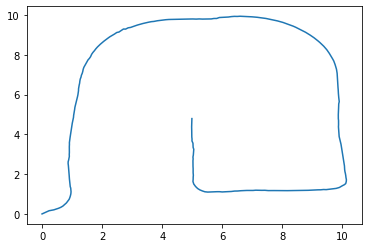

In [153]:
X =[]
for i in range(0,len(m)):
    X.append(m[i])#np.random.multivariate_normal(m[i],P[i]))
x = [a[1] for a in X]
y = [a[2] for a in X]
fig1 = plt.figure(1)
axes1 = fig1.subplots(1, 1)
axes1.plot(x, y,label='parametric curve')

print(P)

# фильтр частиц для расстояния и угла

In [170]:
# Начальные распределения
m = []
P = []
m.append([0,0,0])
myfile = open('/data files/sensor_data_pf.dat')
R = []
n = 3
k = 0
nn = 0 
N = 10
Y = 0
w = [1/N] * N
x = np.array([[random.random()]*n for i in range(N)])
alpha = [0.1,0.1,0.05,0.05]
nums = []
for line in myfile:
    nn = nn+1
    q = line.split()
    if q[0] == 'ODOMETRY':
        if(len(nums)!= 0):
            # нормировка
            for i in range(N):
                w[i] = math.exp(w[i])
            s = sum(w)
            print("s = ",s)
            w /= s
            # Вычисление оценки матожидания
            m_ = [0.0] * n
            for i in range(N):
                m_  = m_ + w[i] *x[i]
                m_[0] = nrml(m_[0])
            m.append(m_)
        # Ресемплинг
            x = resample(w)
            w = [1/N]*N
        #Берем дельты из Одометрии
        deltar1 = float(q[1])
        deltat = float(q[2])
        deltar2 = float(q[3])
        
        # движение частиц
        for i in range(N):
            x[i] = f(x[i])
        w = np.array([0.0] * N)
        nums = []
        k = 0
    else:
        k = k+1
        num = int(q[1])
        nums.append(num)
        Y = [float(q[2]),float(q[3])]
        for i in range(N):
            delta_x = L[num - 1][1] - x[i][1]
            delta_y = L[num - 1][2] - x[i][2]
            qq = (delta_x * delta_x) + (delta_y * delta_y)
            qq = math.sqrt(qq)
            phi = math.atan2(delta_y,delta_x)  - x[i][0]
            phi = nrml(phi)
            val = (phi - Y[1])**2 + (Y[0] - qq)**2
            w[i] += math.exp(-val/ ((0.2)**2)/2)

num = 
1
ODOMETRY 0.100068080139 0.100249642432 -0.000326992241362

num = 
2
SENSOR 1 2.08219220544 0.311724182123

num = 
3
SENSOR 2 4.01188450412 1.44126366316

num = 
4
ODOMETRY 0.100770135385 0.0999830371692 0.000283319078732

s =  17.338310745979594
num = 
5
SENSOR 1 2.03292033382 0.309629930574

num = 
6
SENSOR 2 3.67779686283 1.3616405663

num = 
7
ODOMETRY 0.100250871824 0.0999613218142 -0.000425899489536

s =  19.080882794164385
num = 
8
SENSOR 1 1.91136870178 0.177168372291

num = 
9
SENSOR 2 4.08834234003 1.33657402646

num = 
10
ODOMETRY 0.0985096726563 0.100081615233 -0.000571339302397

s =  34.027437836467215
num = 
11
SENSOR 1 1.98574147997 0.089747632785

num = 
12
SENSOR 2 3.93046602632 1.29955605297

num = 
13
ODOMETRY 0.101801020564 0.100072032353 -0.000788337604257

s =  45.19366072098549
num = 
14
SENSOR 1 1.67053917265 0.061660128389

num = 
15
SENSOR 2 3.93135144955 1.20012845634

num = 
16
ODOMETRY 0.100732548455 0.0996154508379 -0.000105935989332

s =  47.97334

num = 
305
SENSOR 2 2.06294912659 2.59325343834

num = 
306
SENSOR 3 1.67288678091 -0.569977333256

num = 
307
SENSOR 7 3.99139693975 -1.70109563201

num = 
308
ODOMETRY -0.000357584503237 0.0999979583461 0.000343433781639

s =  26.87972942933558
num = 
309
SENSOR 8 4.72304180002 -2.152587981

num = 
310
SENSOR 1 5.0500335413 -2.8658344534

num = 
311
SENSOR 2 1.98255100087 2.63765385437

num = 
312
SENSOR 3 1.73494869541 -0.681218262697

num = 
313
SENSOR 7 3.99801441934 -1.82089872357

num = 
314
ODOMETRY 0.000620290476892 0.0999470003878 -0.000838335967095

s =  20.007795934068543
num = 
315
SENSOR 8 4.82000162046 -2.17663416724

num = 
316
SENSOR 1 4.7896984766 -2.93673143552

num = 
317
SENSOR 2 2.09267316967 2.67055169125

num = 
318
SENSOR 3 1.66678325737 -0.602963490775

num = 
319
SENSOR 7 4.01771495745 -1.69028901209

num = 
320
ODOMETRY 0.000382389454005 0.100008694003 -0.000235027366354

s =  21.466853149146957
num = 
321
SENSOR 8 5.04318864619 -2.22282624467

num = 
322
SE

num = 
603
SENSOR 7 4.91044475526 -1.53423162043

num = 
604
ODOMETRY 7.68654085475e-05 0.100064376896 -0.000347285122512

s =  10.0
num = 
605
SENSOR 9 0.716009510292 -1.32231452602

num = 
606
SENSOR 3 4.05836894592 -2.31125693262

num = 
607
SENSOR 6 4.70020191847 -0.390682294868

num = 
608
SENSOR 7 4.86373148685 -1.56929948757

num = 
609
ODOMETRY -0.000366336199071 0.100085296763 0.000194856527543

s =  10.0
num = 
610
SENSOR 9 0.718690525633 -1.44144427768

num = 
611
SENSOR 3 3.97174192778 -2.33012742735

num = 
612
SENSOR 6 4.51253709809 -0.491056378731

num = 
613
SENSOR 7 4.82580688187 -1.61311348835

num = 
614
ODOMETRY -0.000542691676545 0.100027219506 -0.000143634057834

s =  10.0
num = 
615
SENSOR 9 0.852397954339 -1.52208071018

num = 
616
SENSOR 3 4.02133139088 -2.34538689579

num = 
617
SENSOR 6 4.39394312607 -0.503493763888

num = 
618
SENSOR 7 4.81123460265 -1.5816623073

num = 
619
ODOMETRY -0.000338327098837 0.0999475165511 -0.000696811302053

s =  10.0
num = 
620

num = 
865
SENSOR 4 4.78300024277 -0.184611496152

num = 
866
SENSOR 5 1.61457584315 0.0300012667976

num = 
867
SENSOR 6 1.33645903435 -2.65659019827

num = 
868
ODOMETRY 0.00032218948586 0.0998511803331 0.0003472668121

s =  22.057111801497904
num = 
869
SENSOR 4 4.61809557694 -0.235944730585

num = 
870
SENSOR 5 1.67346172256 0.0980438083583

num = 
871
SENSOR 6 1.56764537893 -2.65826963558

num = 
872
ODOMETRY 0.000579000360448 0.100089931179 -0.000362694330933

s =  26.434736304910825
num = 
873
SENSOR 4 4.61773693027 -0.233895064666

num = 
874
SENSOR 5 1.66054407293 0.136649840485

num = 
875
SENSOR 6 1.46408042321 -2.68709021799

num = 
876
ODOMETRY -0.00044089900061 0.0999353750811 -1.34281290757e-05

s =  22.778086414502678
num = 
877
SENSOR 4 4.55480271918 -0.2913216657

num = 
878
SENSOR 5 1.50100988483 0.0822156400295

num = 
879
SENSOR 6 1.65425176466 -2.6843419931

num = 
880
SENSOR 7 5.04255929223 -1.4135258173

num = 
881
ODOMETRY 0.000562113155451 0.100147932789 -0.00

num = 
1121
SENSOR 8 4.81561768132 -0.408368753456

num = 
1122
SENSOR 4 0.997563887482 -1.00808040996

num = 
1123
SENSOR 5 4.09903612696 -1.70829343966

num = 
1124
ODOMETRY -0.000759856533389 0.100030188988 2.25987579258e-05

s =  10.0
num = 
1125
SENSOR 8 4.77967072204 -0.373187510037

num = 
1126
SENSOR 4 0.609158909746 -1.21111883929

num = 
1127
SENSOR 5 3.78000240925 -1.65403284021

num = 
1128
ODOMETRY 0.000704420580316 0.100169184112 -0.000101490126114

s =  10.0
num = 
1129
SENSOR 8 4.59679993159 -0.378838534461

num = 
1130
SENSOR 4 0.790242431879 -1.31685583208

num = 
1131
SENSOR 5 3.98771440777 -1.83020211246

num = 
1132
ODOMETRY 0.000181557542154 0.100069708857 1.42478443593e-05

s =  10.0
num = 
1133
SENSOR 8 4.56778014001 -0.36613383574

num = 
1134
SENSOR 4 0.87510561166 -1.44831905134

num = 
1135
SENSOR 5 3.87525047323 -1.69256375124

num = 
1136
ODOMETRY -0.000777139765299 0.1001417134 -0.00079200434962

s =  10.0
num = 
1137
SENSOR 8 4.19719632604 -0.26153420276

num = 
1412
SENSOR 8 0.075021317958 2.66991541795

num = 
1413
SENSOR 1 3.94401764174 2.30453132583

num = 
1414
SENSOR 3 5.04767387692 0.693054605253

num = 
1415
SENSOR 4 4.04181014378 -1.86436690644

num = 
1416
SENSOR 7 1.9697847454 0.0510655998543

num = 
1417
ODOMETRY 7.47546602372e-06 0.0999796433801 -0.000779277957618

s =  63.08075830434348
num = 
1418
SENSOR 8 0.208235129731 2.86726458023

num = 
1419
SENSOR 1 3.54294808766 2.09165642135

num = 
1420
SENSOR 3 4.73828954496 0.641679611239

num = 
1421
SENSOR 4 4.17698527247 -1.82214858142

num = 
1422
SENSOR 7 1.71132485001 0.0983006447776

num = 
1423
ODOMETRY 0.000689383008851 0.0999423918626 3.49513447236e-05

s =  40.06594955890028
num = 
1424
SENSOR 8 0.484016165701 2.9408108201

num = 
1425
SENSOR 1 3.98604758273 2.20091963284

num = 
1426
SENSOR 3 4.69180703169 0.703296950333

num = 
1427
SENSOR 4 4.03432426588 -1.9192180266

num = 
1428
SENSOR 7 1.70662307955 0.0195730144804

num = 
1429
ODOMETRY 0.000371189846191 0.10

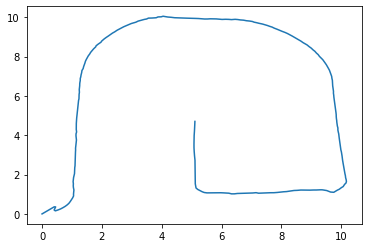

In [171]:
X =[]
for i in range(0,len(m)):
    X.append(m[i])#np.random.multivariate_normal(m[i],P[i]))
x = [a[1] for a in X]
y = [a[2] for a in X]
fig1 = plt.figure(1)
axes1 = fig1.subplots(1, 1)
axes1.plot(x, y,label='parametric curve')